# Regression

Build a regression model that uses historical data for a certain city (London test case) and takes in prediction variables for the weather the next 3 days.

It provides a color coded response based on PM 10 or PM 2.5.





## Data needed




Response variables: Pm 2.5 or pm 10 (mean,max,min)

Predictor variables: Weather data, what month, 

We use data from pollution api (Response variable) and weather api (predict variables)




# To do

Get data on humidity


In [2]:
# Packages we need for the project
# Probably we don't need all of this
import sys
from pandas.core.frame import DataFrame
import requests
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics



# Choose the city
city = 'London'


# You need the csv.files for the city
Measurments = pd.read_csv(f'Data_measurements/{city}.csv')

Weather = pd.read_csv(f'Data_weather/{city}.csv')

In [3]:
# Joining both dataframes
final_df = pd.merge(Measurments, Weather, on= 'Date')

# Get column names
final_df.columns

Index(['ID', 'Date', 'pm10_mean', 'pm25_mean', 'pm10_max', 'pm25_max',
       'pm10_min', 'pm25_min', 'Unnamed: 0', 'tavg', 'prcp', 'wdir', 'wspd',
       'wpgt', 'pres'],
      dtype='object')

In [4]:
### Take care of NA values###

#Find lines with NA values

# Have 4 rows for London
final_df[final_df.isnull().any(axis=1)]

# Drop the NA lines
final_df = final_df.dropna()

In [5]:
# Create a month column in our dataframe
final_df['month'] = pd.DatetimeIndex(final_df['Date']).month
final_df['day'] = pd.DatetimeIndex(final_df['Date']).weekday


# Create the months as a string
# Used for plots later
def month_to_string(x):
    if x == 1:
        return 'January'
    if x == 2:
        return 'February'
    if x == 3:
        return 'March'
    if x == 4:
        return 'April'
    if x == 5:
        return 'Mai'
    if x == 6:
        return 'June'
    if x == 7:
        return 'July'
    if x == 8:
        return 'August'
    if x == 9:
        return 'September'
    if x == 10:
        return 'October'
    if x == 11:
        return 'November'
    return 'December'

final_df['month_string'] = final_df['month'].apply(month_to_string)

# Create a column to show if the day is on a weekend or not
def is_weekend (row):
    if row['day'] > 4:
        return 1
    return 0

final_df['is_weekend'] = final_df.apply (lambda row: is_weekend(row), axis=1)


# Create a log variable 
# Used later for regression
final_df['log_pm10_mean'] = np.log(final_df['pm10_mean'])

# Plotting 

## Response variables: PM2.5 and PM10

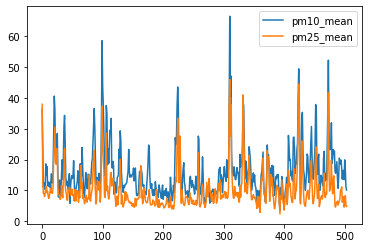

In [6]:
#final_df = final_df.set_index('Date')
final_df.plot(y=['pm10_mean','pm25_mean'])
plt.show()

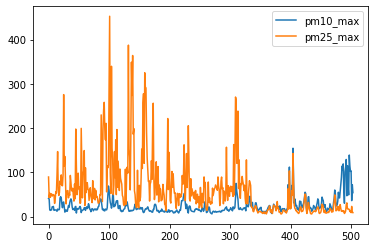

In [7]:
final_df.plot(y=['pm10_max','pm25_max'])
plt.show()

## Day of the week, month and weekend vs Air quality

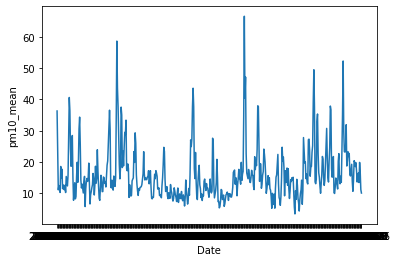

In [8]:
ax = sns.lineplot(x="Date", y="pm10_mean", data=final_df)
plt.show()

In [9]:
final_df.dtypes

ID                 int64
Date              object
pm10_mean        float64
pm25_mean        float64
pm10_max         float64
pm25_max         float64
pm10_min         float64
pm25_min         float64
Unnamed: 0         int64
tavg             float64
prcp             float64
wdir             float64
wspd             float64
wpgt             float64
pres             float64
month              int64
day                int64
month_string      object
is_weekend         int64
log_pm10_mean    float64
dtype: object

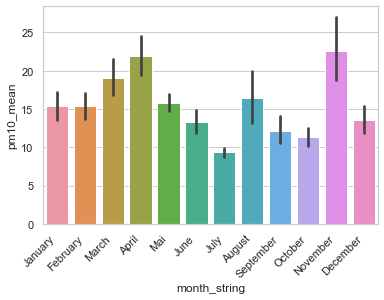

In [10]:
# Plot month vs pm10_mean
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="month_string", y="pm10_mean", data=final_df)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')

plt.show()

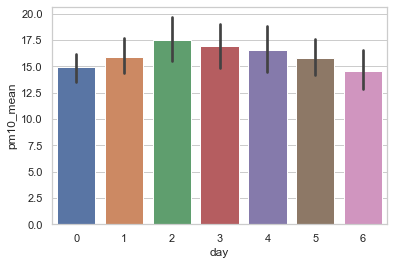

In [11]:
# plot weekday vs pm10_mean
ax = sns.barplot(x="day", y="pm10_mean", data=final_df)

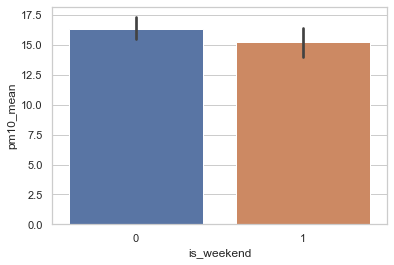

In [12]:
# Plot the is_weekend vs pm10_mean
ax = sns.barplot(x="is_weekend", y="pm10_mean", data=final_df)

## Weather vs Air quality

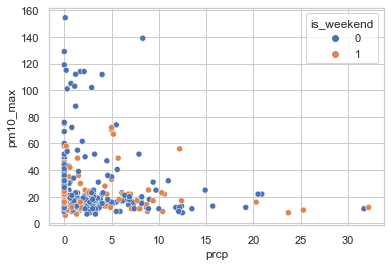

In [13]:
sns.scatterplot(data=final_df, x="prcp", y="pm10_max",hue="is_weekend")
plt.show()

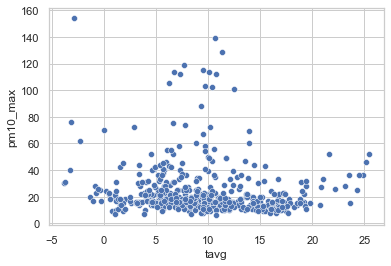

In [14]:
sns.scatterplot(data=final_df, x="tavg", y="pm10_max")
plt.show()

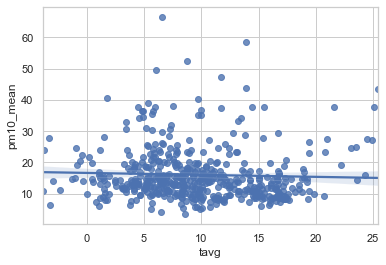

In [15]:
sns.regplot(data=final_df, x="tavg", y="pm10_mean")
plt.show()

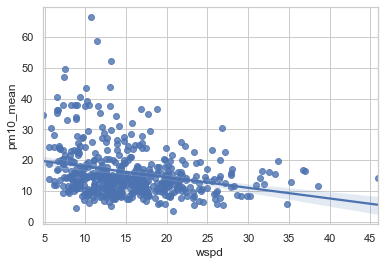

In [16]:
sns.regplot(data=final_df, x="wspd", y="pm10_mean")
plt.show()

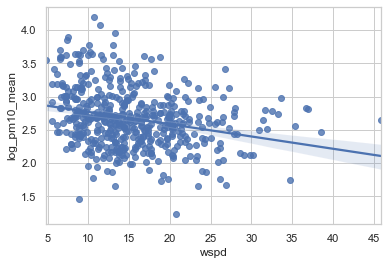

In [17]:
# Plot looks better with log
sns.regplot(data=final_df, x="wspd", y="log_pm10_mean")
plt.show()

# Fitting the model

To fit our model we create a variable based on pm2.5 and pm10, from the "Daily Air Quality Index" found on this site here: https://www.metoffice.gov.uk/weather/guides/air-quality (Write text about this)

The variable we create is based on low pollution vs moderate or higher (0/1). If the average daily mean for pm2.5 goes over 35 or the averge daily mean for pm10 goes over 50 then we classify the pollution as "dangerous" for some people.  

This can be expanded to try and classify for low, moderate, high, very high (not possible for the scope of this project).




In [18]:
final_df.columns

Index(['ID', 'Date', 'pm10_mean', 'pm25_mean', 'pm10_max', 'pm25_max',
       'pm10_min', 'pm25_min', 'Unnamed: 0', 'tavg', 'prcp', 'wdir', 'wspd',
       'wpgt', 'pres', 'month', 'day', 'month_string', 'is_weekend',
       'log_pm10_mean'],
      dtype='object')

In [19]:
# https://www.metoffice.gov.uk/weather/guides/air-quality
# pm over 35?



# Create a classifier column based on the mean of 2.5 or 10
# Can use pm10 or 2.5
def is_pollution (row):
    if row['pm10_mean'] > 40 or row['pm25_mean'] > 30:
        return 1
    return 0

final_df['is_pollution'] = final_df.apply (lambda row: is_pollution(row), axis=1)




In [20]:
final_df.groupby(['is_pollution']).count()

,ID,Date,pm10_mean,pm25_mean,pm10_max,pm25_max,pm10_min,pm25_min,Unnamed: 0,tavg,prcp,wdir,wspd,wpgt,pres,month,day,month_string,is_weekend,log_pm10_mean
is_pollution,,,,,,,,,,,,,,,,,,,,
0,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484
1,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16


In [21]:
possible_categories_month = ['January','February','March','April','Mai','June',
                       'July','August','September','October','November','December']
possible_categories_weekend = [0,1]

final_df['month_string'] = final_df['month_string'].astype(pd.CategoricalDtype(categories=possible_categories_month))
final_df['is_weekend'] = final_df['is_weekend'].astype(pd.CategoricalDtype(categories=possible_categories_weekend))

In [22]:
# Create the logistic regression model
# Create X-matrix (Design matrix) and y the response variable
X = final_df[['is_weekend','wpgt','month_string','tavg']]
#X = final_df[['is_weekend','wspd','tavg']]
Y = final_df['is_pollution']
 
# Create dummy variable for categorical columns
X = pd.get_dummies(data=X, drop_first=True)

# Fit a logistic regression model
clf = LogisticRegression(random_state=0).fit(X, Y)

In [23]:
print(clf.intercept_)
print(clf.coef_)
print(X.columns)
#coeff_parameter = pd.DataFrame(clf.coef_,X.columns,columns=['Coefficient'])

[1.20204927]
[[-0.18363356  0.03234439 -0.08937185 -0.49719043  0.69331768  0.30225627
  -0.70666818 -0.51386424 -0.47309794  0.07041339 -0.54473488 -0.38206251
   1.51904829 -0.47732165]]
Index(['wpgt', 'tavg', 'is_weekend_1', 'month_string_February',
       'month_string_March', 'month_string_April', 'month_string_Mai',
       'month_string_June', 'month_string_July', 'month_string_August',
       'month_string_September', 'month_string_October',
       'month_string_November', 'month_string_December'],
      dtype='object')


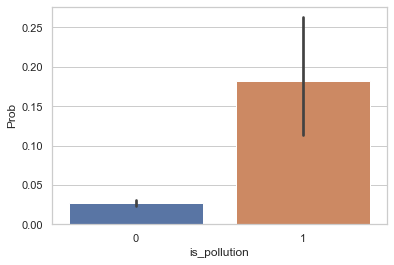

In [24]:
# Here we can see that the model is not predicting high probabilites


final_df['Prob'] = clf.predict_proba(X)[:,1]


# Predictions
ax = sns.barplot(x="is_pollution", y="Prob",data = final_df)

In [25]:
y = final_df['is_pollution']
pred = final_df['Prob']

fpr, tpr, thresholds = metrics.roc_curve(y, pred)
metrics.auc(fpr, tpr)

0.9018595041322313

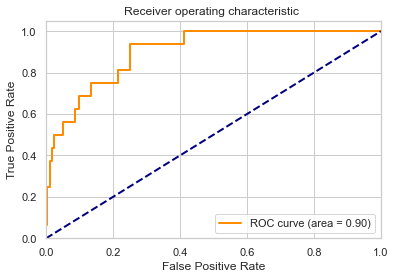

In [26]:
# ROC curve to see how good the model is doing
# True positive rate vs false positive rate

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

# Prediction for the next 5 days

In [27]:
# Import packages
import sys
from pandas.core.frame import DataFrame
import requests
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings
import numpy as np


from datetime import datetime as dt
from datetime import date
from datetime import timedelta
from meteostat import Point
from meteostat import Daily 

In [28]:
# Fetch data
cities_of_interest = {"Akureyri": "IS", "London": "GB", 
    "Mexico City": "MX", "Newcastle": "GB", "Reykjavík":"IS"}
data_dirs = {"weather": "data/weather", "pollution": "data/pollution"}

def fetch_weather_data(city_name, date_from=date.today() - timedelta(30), date_to=date.today()):
    ''' Fetch weather measurements for a particular city during a particular time.

    '''
    #We limit to the 5 cities above
    city_country = get_city_country(city_name)

    #Since both the weather api and pandas dataframe operate on the datetime level
    #cast date to datetime early 
    dt_from = cast_date_to_datetime(date_from)
    dt_to = cast_date_to_datetime(date_to)

    weather = fetch_data_from_csv('weather', city_country[0], dt_from= dt_from, dt_to=dt_to)

    if(weather.empty):
        weather = fetch_data_from_api('weather', city_country, dt_from, dt_to)
    #The complicated case is: a file exists but not all the data is there
    elif(needs_more_data(weather, dt_from, dt_to)):
        weather = partial_csv_update('weather', weather, city_country)
    return weather

def fetch_pollution_data(city_name, date_from=date.today() - timedelta(days=30), date_to=date.today()):

    city_country = get_city_country(city_name)

    #Since both the weather api and pandas dataframe operate on the datetime level
    #cast date to datetime early 
    dt_from = cast_date_to_datetime(date_from)
    dt_to = cast_date_to_datetime(date_to)

    pollution = fetch_data_from_csv('pollution', city_country[0], dt_from = dt_from, dt_to = dt_to)

    if(pollution.empty):
        pollution = fetch_data_from_api('pollution', city_country, dt_from, dt_to)
    elif(needs_more_data(pollution, dt_from, dt_to)):
        pollution = partial_csv_update('pollution', pollution, city_country)
    return pollution 

def cast_date_to_datetime(date):
    midnight_time = dt.min.time()
    return dt.combine(date, midnight_time)

def needs_more_data(data, dt_from, dt_to):
    delta_days = (dt_to - dt_from).days + 1
    data_subset = data[(dt_from <= data.index) & (data.index <= dt_to)]
    return len(data_subset) < delta_days

def get_city_country(city_name):
    if city_name not in cities_of_interest.keys():
        raise Exception(f"Please enter one of {cities_of_interest}.")
    return (city_name, cities_of_interest[city_name])

def fetch_data_from_csv(type, city_name, **kwargs):
    file_dir = data_dirs[type]
    
    #Empty dataframe for when there is no csv file
    data = pd.DataFrame({'' : []})

    try:
        data = pd.read_csv(f'{file_dir}/{city_name}.csv', index_col='date', parse_dates=['date'])
        if (kwargs):
            return data[(kwargs['dt_from'] <= data.index) & (data.index <= kwargs['dt_to'])]
    except FileNotFoundError:
        print(f"No historical {type} data found locally. Using API to get fresh data.\n")
    return data

def fetch_data_from_api(type, city_and_country, date_from, date_to):
    # The first part of the tuple is the city and our csv data is organized by city name.
    city_coords = query_lat_long(city_and_country)

    if(type=='weather'):
        data = query_historical_weather(city_coords, date_from, date_to)
    elif(type=='pollution'):
        data = query_historical_polluiton(city_and_country, date_from, date_to)

    #Write new csv file
    dir_name = data_dirs[type]
    data.to_csv(f'{dir_name}/{city_and_country[0]}.csv')
    return data

def partial_csv_update(type, from_api, city_and_country):
    #Note that this is all of our CSV data for the city. no time filter
    from_file = fetch_data_from_csv(type, city_and_country[0])

    total_data = pd.concat([from_file, from_api])
    unique_days = total_data.drop_duplicates()
    unique_days = unique_days.sort_values('date')

    dir_name = data_dirs[type]
    unique_days.to_csv(f'{dir_name}/{city_and_country[0]}.csv')
    return unique_days

def filter_results_to_country(geoapi_response_data, country):
    #If there are multiple cities with the same name, we choose the most populated
    filter_by_country = [resp for resp in geoapi_response_data if resp['country_code'] == country]
    # 
    sorted_by_pop = sorted(filter_by_country, key = lambda resp: resp['population'] if 'population' in resp else 0, reverse=True)
    result = sorted_by_pop[0]

    # Relevant subset of the result dict
    return {key: result[key] for key in ('latitude', 'longitude', 'elevation', 'population')}

def query_lat_long(city_country):
    params_dict = {
        'name': city_country[0],
        #Default is 10 but since newcastle gives 9, we might hit the limit
        'count': 100
    }

    # Since the user gives us more than 3 chars, the api performs fuzzy matching. So we do not
    # need to worry abt spelling
    resp = requests.get('https://geocoding-api.open-meteo.com/v1/search', params_dict)
    data = resp.json()
    
    return filter_results_to_country(data['results'], city_country[1])

def query_historical_weather(lat_long_elevation, date_from, date_to):
    # Since we have dates and the api uses time, we need to convert from date to datetime
    midnight_time = dt.min.time()
    dt_from = dt.combine(date_from, midnight_time)
    dt_to = dt.combine(date_to, midnight_time)
    
    location = Point(
        lat_long_elevation['latitude'], 
        lat_long_elevation['longitude'], 
        lat_long_elevation['elevation'])

    daily = Daily(location, start=dt_from, end=dt_to)
    
    # Ask meteostat to fill in any gaps in the data
    daily.normalize()
    data = daily.fetch()
    
    #tavg=Temp average (C).prcp=Total precipitation(mm). wdir=Wind direction(degrees)
    #wspd=Average wind speed(km/h).wpgt=Wind peak gust(km/hr). pres=Sea-level air pressure(hpa)
    #rhum=Relative humidity(does not work)
    response = data[['tavg', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']]

    #Since time is an index, simply calling rename does not work
    tidy = response.rename_axis(index={"time": "date"})

    return tidy

def get_weather(city_country):
    coords = query_lat_long(city_country)
    return query_historical_weather(coords)


#From fetching measurements data notebook

# TODO
# 1. Drop the ID column, don't need to write that into the file
# 2. The dates are not the same for all cities.. Look into that
# 3. Maybe count locations and provide that into the dataframe as well. 
#    It's relevent to know how many measures are in the city.
# 4. Can we choose certain type of measures

# Filter what city we want to get
def filter_results_to_country(geoapi_response_data, country):
    #If there are multiple cities with the same name, we choose the most populated
    filter_by_country = [resp for resp in geoapi_response_data if resp['country_code'] == country]
    # 
    sorted_by_pop = sorted(filter_by_country, key = lambda resp: resp['population'] if 'population' in resp else 0, reverse=True)
    result = sorted_by_pop[0]

    # Relevant subset of the result dict
    return {key: result[key] for key in ('latitude', 'longitude', 'elevation', 'population')}

def query_historical_polluiton(city_country, date_from, date_to):
    '''
    This function takes in a city, parameter and date and writes data into a csv.file
    Input:
        city: name of a city (string)
        ???parameter: List of strings that represent the parameters wanted to calculate
        date_from: measurments after this date will be calculated
        date_to: Measures until this date will be calculated
    '''
    
    # Explicitly use v2 of the api http://dhhagan.github.io/py-openaq/api.html
    api = openaq.OpenAQ(version ='v2')
    # Get the longitude and latitude for the city
    location = query_lat_long(city_country)
    coords = f'{location["latitude"]},{location["longitude"]}'
    
    # Call the location api to check for the first date updated
    locations = api.locations(coordinates = coords,radius = 10000,df = True)

    min_date = locations["firstUpdated"].min()
    min_date = min_date.tz_convert(None)
    min_date = pd.to_datetime(min_date) 
    
    if min_date > date_from:
        date_from = min_date  
    
    # Number of days we want measurements for
    day_diff = (date_to - date_from).days
    
    # How we split the call between days to the API
    split_days = 30

    # Number of 30 day blocks in our range
    number_months = day_diff // split_days

    # Initialize the start date
    start = date_from

    # Add measurements data frame 30 days at a time
    # An extra iteration for the remaining <30 days
    for n in range(number_months + 1):
        
        # Find the end date
        end = start + timedelta(days = split_days)
        
        # Fetch the data from the measurment api
        df_api = api.measurements(coordinates = coords, radius = 5000, df = True, 
                                  limit = 30000, parameter = ["pm25", "pm10"], value_from = 0,
                              date_from = start, date_to = end)
        
        # Start as the last end date
        start = end

        # For the first iteration create df
        if n == 0: 
            df = df_api.copy()
        # After the first iteration append the data
        else:
            df = df.append(df_api)
    
    ## Data prepping 

    # Change the index
    df.index.name = 'Date.local'
    df.reset_index(inplace=True)
    df['date'] = df['Date.local'].dt.strftime('%Y-%m-%d')
    df['value'] = df['value'].astype(float, errors = 'raise')

    # Calculate mean, max and min value for each date
    Result_mean = df.groupby(['date', 'parameter'],as_index=False)['value'].mean()
    Result_max = df.groupby(['date', 'parameter'],as_index=False)['value'].max()
    Result_min = df.groupby(['date', 'parameter'],as_index=False)['value'].min()

    # Pivot the tables to wide format
    ResultWide_mean = Result_mean.pivot_table(index='date',columns='parameter', values='value')
    ResultWide_max = Result_max.pivot_table(index='date',columns='parameter', values='value')
    ResultWide_min = Result_min.pivot_table(index='date',columns='parameter', values='value')

    # Rename the columns to distinguish
    ResultWide_mean.rename(columns={"pm10": 'pm10_mean', 'pm25': 'pm25_mean'}, inplace=True)
    ResultWide_max.rename(columns={"pm10": 'pm10_max', 'pm25': 'pm25_max'}, inplace=True)
    ResultWide_min.rename(columns={"pm10": 'pm10_min', 'pm25': 'pm25_min'}, inplace=True)

    # Join mean and max first
    df_first_join = pd.merge(ResultWide_mean, ResultWide_max, left_index=True, right_index=True)

    # Join now to min
    ResultWide = pd.merge(df_first_join, ResultWide_min, left_index=True, right_index=True)

    # Change the index (Can we drop the ID column?)
    ResultWide.index.name = 'date'
    ResultWide.reset_index(inplace=True)
    ResultWide.index.name = 'ID'

    return ResultWide 
    
# # Call the function
# city = 'London'
# date_from = pd.to_datetime('2020-01-01') 
# date_to = pd.to_datetime('2021-05-01')

# #measurement_to_csv(city,date_from,date_to)
# weather_data = fetch_weather_data(city, date_from=date.today() - timedelta(days=365))
# pollution_data = fetch_pollution_data(city)

# fubbus = "Fubbus"

In [29]:

def model_prediction_london():
    '''
    This function takes in variables (weather data, date) and 
    provides an prediction of whether next two days will have good 
    air quality or not (probability) based on weather forecast for the
    next two days.  
    '''

    # Choose the city
    city = 'London'

    # Set time period
    start_date = date.today() + timedelta(days=1)
    end_date = date.today() + timedelta(days=2)


    date_from = pd.to_datetime(start_date)
    date_to = pd.to_datetime(end_date)
    Variables = fetch_weather_data(city, date_from=date_from, date_to= date_to)

    Variables['Date'] = Variables.index

    # Variable creation
    # Create the variables needed for the prediction

    Variables['Date'] = Variables.index
    Variables['month'] = pd.DatetimeIndex(Variables['Date']).month
    Variables['day'] = pd.DatetimeIndex(Variables['Date']).weekday
    Variables['month_string'] = Variables['month'].apply(month_to_string)
    Variables['is_weekend'] = Variables.apply (lambda row: is_weekend(row), axis=1)


    Variables['month_string'] = Variables['month_string'].astype(pd.CategoricalDtype(categories=possible_categories_month))
    Variables['is_weekend'] = Variables['is_weekend'].astype(pd.CategoricalDtype(categories=possible_categories_weekend))


    # Create X-matrix (Design matrix) and y the response variable
    X_prediction = Variables[['is_weekend','wpgt','month_string','tavg']]


    # Create dummy variable for categorical columns
    X_prediction = pd.get_dummies(data=X_prediction, drop_first=True)

    return(clf.predict_proba(X_prediction)[:,1])

model_prediction_london()

array([0.0103992 , 0.00121948])

# MORE TESTS!










# TEST!!



In [53]:
# Use log_pm10_mean as y
# Try a model: Month, is_weekend, and windspead, avg_

# Create X-matrix (Design matrix) and y the response variable
X = final_df[['is_weekend','wspd','month_string','tavg','wpgt','prcp']]
#X = final_df[['is_weekend','wspd','tavg']]
Y = final_df['log_pm10_mean']
 
# Create dummy variable for categorical columns
X = pd.get_dummies(data=X, drop_first=True)
X.head(100)
#Y.head(100)

,is_weekend,wspd,tavg,wpgt,prcp,month_string_August,month_string_December,month_string_February,month_string_January,month_string_July,month_string_June,month_string_Mai,month_string_March,month_string_November,month_string_October,month_string_September
0,0,6.6,4.8,20.4,0.0,0,0,0,1,0,0,0,0,0,0,0
1,0,16.1,7.3,37.0,0.0,0,0,0,1,0,0,0,0,0,0,0
2,0,17.3,7.0,35.2,1.5,0,0,0,1,0,0,0,0,0,0,0
3,1,12.8,4.5,29.6,0.0,0,0,0,1,0,0,0,0,0,0,0
4,1,11.1,5.5,25.9,0.0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,12.7,12.5,31.5,0.9,0,0,0,0,0,0,0,0,0,0,0
97,0,8.6,11.0,24.1,0.0,0,0,0,0,0,0,0,0,0,0,0
98,0,8.8,13.5,20.4,0.0,0,0,0,0,0,0,0,0,0,0,0
99,0,11.4,13.9,29.6,0.0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
# Fit the model

model = LinearRegression()
model.fit(X,Y)

LinearRegression()

In [81]:
# Intercept and coefficients
print(model.intercept_)
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

3.022087739844352


,Coefficient
is_weekend,-0.025836
wspd,-0.020933
tavg,0.028128
month_string_August,-0.575439
month_string_December,-0.318377
month_string_February,-0.111406
month_string_January,-0.200975
month_string_July,-0.953673
month_string_June,-0.602424
month_string_Mai,-0.312728


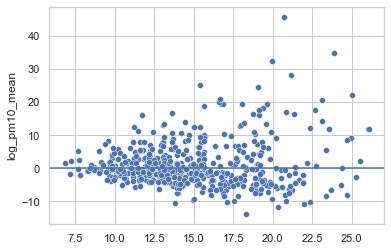

In [82]:
# Not a constant variance, hard to pick up the largest values

# Predict and calculate residuals
predictions = model.predict(X)
predictions_exp = np.exp(predictions)
residuals = np.exp(Y) - predictions_exp

# Plot the fitted vs residual plot
ax = sns.scatterplot(x= predictions_exp,y = residuals)
# Add a horizontal line
ax.axhline(0)
plt.show()